In [133]:
from aocd.models import Puzzle

puzzle = Puzzle(year=2023, day=23)

def parses(input):
    return [
        ['.#<>^v'.index(c) for c in line]
    for line in input.strip().split('\n')]


data = parses(puzzle.input_data)

In [134]:
EMPTY, WALL, LEFT, RIGHT, UP, DOWN = range(6)

In [135]:
sample = parses("""#.#####################
#.......#########...###
#######.#########.#.###
###.....#.>.>.###.#.###
###v#####.#v#.###.#.###
###.>...#.#.#.....#...#
###v###.#.#.#########.#
###...#.#.#.......#...#
#####.#.#.#######.#.###
#.....#.#.#.......#...#
#.#####.#.#.#########v#
#.#...#...#...###...>.#
#.#.#v#######v###.###v#
#...#.>.#...>.>.#.###.#
#####v#.#.###v#.#.###.#
#.....#...#...#.#.#...#
#.#########.###.#.#.###
#...###...#...#...#.###
###.###.#.###v#####v###
#...#...#.#.>.>.#.>.###
#.###.###.#.###.#.#v###
#.....###...###...#...#
#####################.#""")

In [136]:
# data = sample

In [137]:
def viz(visited):
    board = data.copy()
    for z in visited:
        i, j = int(z.real), int(z.imag)
        board[i,j] = 10
    plt.imshow(board)
    plt.show()

In [138]:
data = np.array(data, dtype=np.int8)
not_wall = np.pad(data != WALL, [(1,1),(1,1)])
intersections = (sum([
    not_wall[2:,1:-1],
    not_wall[:-2,1:-1],
    not_wall[1:-1,2:],
    not_wall[1:-1,:-2]
]) > 2) * not_wall[1:-1,1:-1]
intersection_coords = set([i+1j*j for i,j in np.argwhere(intersections)])



start = 1j * np.array([i for i, val in enumerate(data[0]) if val == EMPTY]).item()
end = len(data)-1 + 1j * np.array([i for i, val in enumerate(data[-1]) if val == EMPTY]).item()

intersection_coords |= set([start, end])

distances = {}


map_ = {i+j*1j: val for i, row in enumerate(data) for j, val in enumerate(row)}
for node in intersection_coords:
    stack = [(node, 0, 0)]
    while stack:
        pos, prev_delta, pathlen = stack.pop()
        
        for delta in [1,-1,1j,-1j]:
            new_pos = pos + delta
            if new_pos not in map_ or map_[new_pos] == WALL:
                continue
            if delta == -prev_delta:
                continue
            if new_pos in intersection_coords:
                distances[node, new_pos] = pathlen
                continue
            stack.append((new_pos, delta, pathlen+1))

distances

{((109+113j), (103+83j)): 179,
 ((109+113j), (111+129j)): 97,
 ((109+113j), (77+101j)): 187,
 ((109+113j), (135+107j)): 139,
 ((11+61j), (9+29j)): 253,
 ((11+61j), (19+87j)): 269,
 ((11+61j), (33+55j)): 119,
 ((33+55j), (39+41j)): 43,
 ((33+55j), (29+79j)): 127,
 ((33+55j), (11+61j)): 119,
 ((33+55j), (57+55j)): 147,
 ((135+107j), (137+79j)): 145,
 ((135+107j), (127+131j)): 179,
 ((135+107j), (109+113j)): 139,
 ((15+105j), (19+87j)): 137,
 ((15+105j), (29+127j)): 431,
 ((15+105j), (37+105j)): 93,
 ((31+15j), (39+41j)): 197,
 ((31+15j), (11+17j)): 177,
 ((31+15j), (59+9j)): 233,
 ((83+41j), (83+5j)): 207,
 ((83+41j), (87+57j)): 87,
 ((83+41j), (61+41j)): 153,
 ((83+41j), (103+37j)): 91,
 ((59+9j), (61+41j)): 233,
 ((59+9j), (31+15j)): 233,
 ((59+9j), (83+5j)): 131,
 ((103+37j), (105+11j)): 159,
 ((103+37j), (109+63j)): 127,
 ((103+37j), (83+41j)): 91,
 ((103+37j), (129+39j)): 127,
 ((67+137j), (55+113j)): 223,
 ((67+137j), (29+127j)): 203,
 ((67+137j), (89+135j)): 115,
 ((57+55j), (61+4

In [139]:
from collections import defaultdict

In [140]:
graph = defaultdict(list)
for (a, b), dist in distances.items():
    graph[a].append((b, dist+1))

In [144]:
graph[end]

[((127+131j), 77)]

In [147]:
gate, gate_dist = graph[end][0]

In [151]:
%%time
# %%time
stack = [(start, set([start]), 0)]
max_len = 0
while stack:
    node, visited, pathlen = stack.pop()

    for neigh, dist in graph[node]:
#         if neigh == end:
#             max_len = max(max_len, pathlen+dist)
        if neigh == gate:
            max_len = max(max_len, pathlen+dist+gate_dist)
            continue
        if neigh in visited:
            continue
        stack.append((neigh, visited | set([neigh]), pathlen+dist))
max_len

CPU times: user 11.4 s, sys: 4.35 ms, total: 11.4 s
Wall time: 11.5 s


6230

In [109]:
import string
string.ascii_uppercase

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

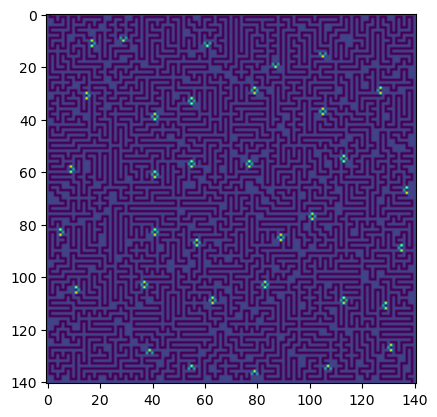

In [110]:
plt.imshow(data)

In [112]:
len(intersection_coords)

36

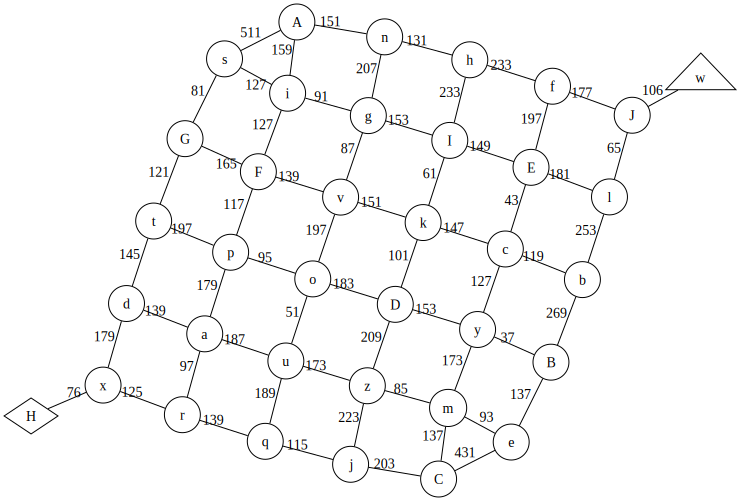

In [164]:
from graphviz import Graph

def visualize_graph(nodes, distances: dict[str, list[str]], start, end) -> None:
    dot = Graph(comment='The Graph', engine='neato')    
    # Add nodes and edges to the graph
    names = {z:string.ascii_letters[i] for i, z in enumerate(nodes)}
    for node in nodes:
        shape = 'circle'
        if node == start:
            shape = 'triangle'
        elif node == end:
            shape = 'diamond'
        dot.node(names[node], shape=shape)
    done = set()
    for (n, m), dist in distances.items():
        if (n,m) not in done:
            dot.edge(names[n], names[m], label=str(dist))
            done |= set([(n,m),(m,n)])

    # Render the graph to a file (e.g., 'graphviz_output') and view it
    return dot
#     dot.render('graphviz_output', view=True, format='pdf', engine='neato')
#     return dot


visualize_graph(intersection_coords, distances, start, end)


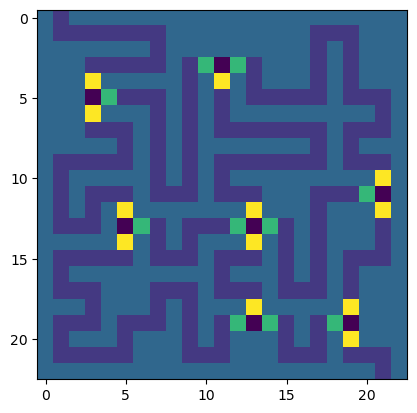

In [34]:
plt.imshow(data + -1 * intersections)a

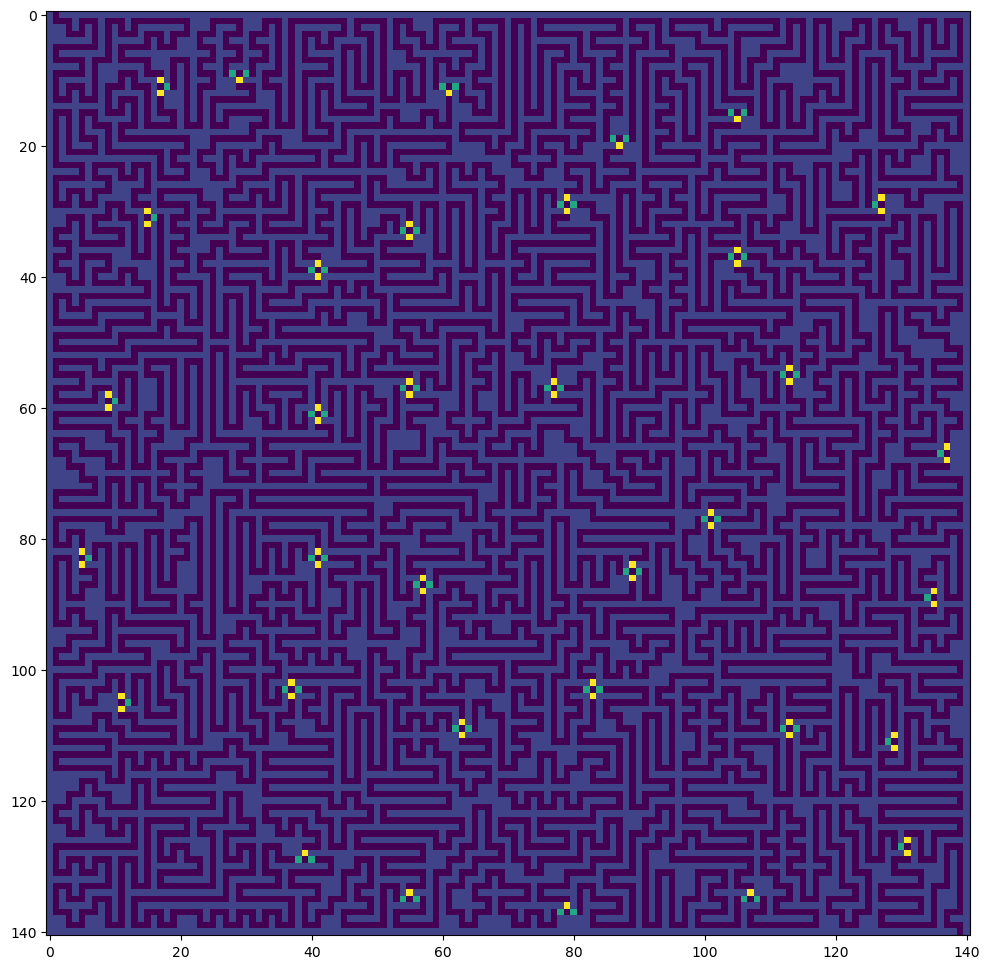

In [4]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
plt.imshow(data) # != 1)

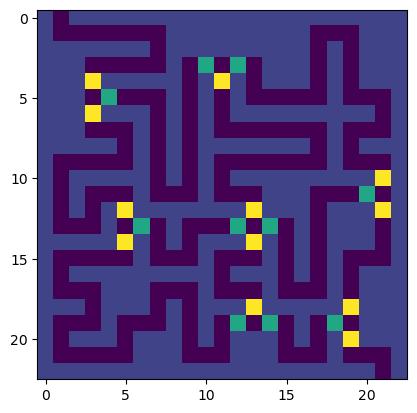

In [5]:
plt.imshow(sample)

In [40]:
def viz(visited):
    board = data.copy()
    for z in visited:
        i, j = int(z.real), int(z.imag)
        board[i,j] = 10
    plt.imshow(board)
    plt.show()

In [6]:
def solve_a(data):
    data = np.array(data, dtype=np.uint8)

    map_ = {i+j*1j: val for i, row in enumerate(data) for j, val in enumerate(row)}

    start = 1j * np.array([i for i, val in enumerate(data[0]) if val == EMPTY]).item()
    end = len(data)-1 + 1j * np.array([i for i, val in enumerate(data[-1]) if val == EMPTY]).item()

    stack = [(start, set([start]))]
    max_len = 0
    i = 0
    while stack:
        i += 1
        pos, visited = stack.pop()
    #     if i % 10 == 0:
    #         viz(visited)

        valid_directions = {
            EMPTY: [1,-1,1j,-1j],
            LEFT: [-1j],
            RIGHT: [1j],
            UP: [-1],
            DOWN: [1]
        }[map_[pos]]

        for delta in valid_directions:
            new_pos = pos + delta
            if new_pos not in map_ or map_[new_pos] == WALL or new_pos in visited:
                continue
            if new_pos == end:
    #             print(len(visited))
                max_len = max(max_len, len(visited))
                continue
            stack.append((new_pos, visited | set([new_pos])))

    return max_len

In [7]:
solve_a(sample)

94

In [8]:
solve_a(data)

1930

In [9]:
def solve_b(data):
    data = np.array(data, dtype=np.uint8)

    map_ = {i+j*1j: val for i, row in enumerate(data) for j, val in enumerate(row)}

    start = 1j * np.array([i for i, val in enumerate(data[0]) if val == EMPTY]).item()
    end = len(data)-1 + 1j * np.array([i for i, val in enumerate(data[-1]) if val == EMPTY]).item()

    stack = [(start, set([start]))]
    max_len = 0
    i = 0
    while stack:
        i += 1
        pos, visited = stack.pop()
    #     if i % 10 == 0:
    #         viz(visited)

        for delta in [1,-1,1j,-1j]:
            new_pos = pos + delta
            if new_pos not in map_ or map_[new_pos] == WALL or new_pos in visited:
                continue
            if new_pos == end:
    #             print(len(visited))
                max_len = max(max_len, len(visited))
                continue
            stack.append((new_pos, visited | set([new_pos])))

    return max_len

In [10]:
solve_b(sample)

154

In [ ]:
solve_b(data)

In [90]:
from collections import Counter

In [92]:
Counter([82,94,86,82,74,90,94,]) - Counter([94,90,86,82,82,74])

Counter({94: 1})

In [77]:
map_[2+3j]

0

In [78]:
data[2,3]

1

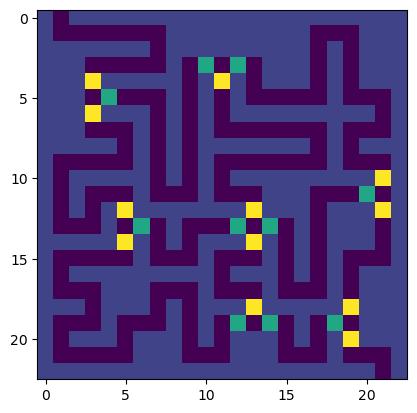

In [76]:
plt.imshow(data)

In [15]:
def solve_a(data):
    pass

In [2]:
def solve_b(data):
    pass